# Маркировка комментариев

Интернет-магазин «Викишоп» запускает новый сервис: теперь клиенты могут редактировать и дополнять описания товаров, а также комментировать изменения, внесенные другими пользователями. 

Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

## Подготовка данных

Загрузим и импортируем необходимые библиотеки.

In [5]:
import pandas as pd
import numpy as np
import time
import re
import spacy
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import warnings
warnings.simplefilter('ignore')
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_selection import RFE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import shuffle
from pymystem3 import Mystem
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from tqdm.notebook import tqdm
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Дима\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Дима\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Дима\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Сохраним данные в датафрейм.

In [6]:
df = pd.read_csv('toxic_comments.csv')

### Изучение данных

#### Общее изучение данных

Выведем общую информацию о датафрейме, а также первые и последние 5 строк.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
 3   lemm_text   159281 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.9+ MB


In [8]:
df

,Unnamed: 0,text,toxic,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,Explanation why the edit make under my usernam...
1,1,D'aww! He matches this background colour I'm s...,0,D aww he match this background colour I m seem...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man I m really not try to edit war it s ju...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...,...
159287,159287,""":::::And for the second time of asking, when ...",0,and for the second time of ask when your view ...
159288,159288,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...
159289,159289,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm there s no actual article for pros...
159290,159290,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


Построим гистограмму.

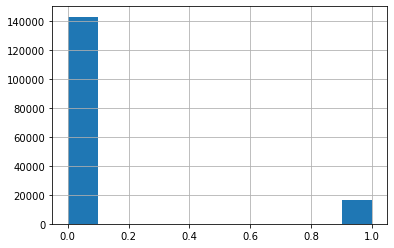

In [9]:
df['toxic'].hist();

**Налицо дисбаланс классов**.

Выведем соотношение комментариев.

In [10]:
(
    df.query('toxic == 0')['toxic'].count() /
    df.query('toxic == 1')['toxic'].count()
)

8.841344371679229

## Предобработка данных

Удалим столбец Unnamed: 0.

In [11]:
df = df.drop('Unnamed: 0', axis=1)

## Подготовка данных к машинному обучению

### Создание корпуса

In [12]:
corpus = list(df['text'])

### Лемматизация

In [13]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = ' '.join(text.split())
    
    return text

In [14]:
nlp = spacy.load("en_core_web_sm")

def lemmatize(text):
    raw_text = nlp(text)
    lemm_text = " ".join([token.lemma_ for token in raw_text])
        
    return lemm_text

In [ ]:
%%time 

df['lemm_text'] = df['text'].progress_apply(clear_text)
df['lemm_text'] = df['lemm_text'].progress_apply(lemmatize)

In [15]:
df

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,D aww he match this background colour I m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man I m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...
159287,""":::::And for the second time of asking, when ...",0,and for the second time of ask when your view ...
159288,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...
159289,"Spitzer \n\nUmm, theres no actual article for ...",0,Spitzer Umm there s no actual article for pros...
159290,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


### Разбивка данных на выборки

In [16]:
(
    df_train, df_test,
    corpus_train, corpus_test,
    y_train, y_test
) = train_test_split(df,
                     df['lemm_text'].values.astype('U'),
                     df['toxic'],
                     test_size=.1,
                     random_state=12345)

### TF-IDF

In [17]:
count_tf_idf = TfidfVectorizer(stop_words=set(nltk_stopwords.words('english')))

In [18]:
tf_idf_train = count_tf_idf.fit_transform(corpus_train)

pd.DataFrame(tf_idf_train)

,0
0,"(0, 59005)\t0.199172839095367\n (0, 127965)..."
1,"(0, 40511)\t0.19075424015601178\n (0, 11803..."
2,"(0, 114975)\t0.09738204185888782\n (0, 9248..."
3,"(0, 8055)\t0.17866335905994768\n (0, 1415)\..."
4,"(0, 130261)\t0.11026286338022546\n (0, 1275..."
...,...
143357,"(0, 41138)\t0.46220412241401815\n (0, 54573..."
143358,"(0, 78573)\t1.0"
143359,"(0, 138802)\t0.19947411265277437\n (0, 1303..."
143360,"(0, 130696)\t0.4995659920643137\n (0, 69841..."


In [19]:
tf_idf_test = count_tf_idf.transform(corpus_test)

pd.DataFrame(tf_idf_test)

,0
0,"(0, 144568)\t0.18597820644763954\n (0, 1380..."
1,"(0, 126771)\t0.21664798401374535\n (0, 8955..."
2,"(0, 126771)\t0.1365726979401494\n (0, 11777..."
3,"(0, 135029)\t0.2061014099533578\n (0, 13388..."
4,"(0, 144568)\t0.19095453857455064\n (0, 1428..."
...,...
15925,"(0, 140631)\t0.5087649959044391\n (0, 12677..."
15926,"(0, 140631)\t0.24782808424260955\n (0, 1285..."
15927,"(0, 144361)\t0.071012929993899\n (0, 142208..."
15928,"(0, 144568)\t0.06302087620682466\n (0, 1443..."


## Машинное обучение

### LogisticRegression

In [20]:
param_set = {
      'C'         : [5,6,7,8,9,10,11,12,13,14,15]
}

grid_lr = GridSearchCV(LogisticRegression(random_state=12345), param_grid=param_set, scoring='f1')

In [21]:
%%time

grid_lr.fit(tf_idf_train, y_train)

CPU times: total: 16min 31s
Wall time: 4min 16s


GridSearchCV(estimator=LogisticRegression(random_state=12345),
             param_grid={'C': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]},
             scoring='f1')

In [22]:
grid_lr.best_score_, grid_lr.best_params_

(0.7719796305300336, {'C': 14})

### CatBoostClassifier

In [23]:
param_set = {
      'depth'         : [4,7],
      'learning_rate' : [0.02,0.04],
      'iterations'    : [5,10]
}

grid_catboost = GridSearchCV(CatBoostClassifier(random_state=12345), param_grid=param_set, scoring='f1')

In [24]:
%%time

grid_catboost.fit(tf_idf_train, y_train)

0:	learn: 0.6722111	total: 655ms	remaining: 2.62s
1:	learn: 0.6518529	total: 1.05s	remaining: 1.58s
2:	learn: 0.6327961	total: 1.5s	remaining: 1s
3:	learn: 0.6145784	total: 2.13s	remaining: 533ms
4:	learn: 0.5967799	total: 2.65s	remaining: 0us
0:	learn: 0.6719816	total: 422ms	remaining: 1.69s
1:	learn: 0.6517908	total: 841ms	remaining: 1.26s
2:	learn: 0.6325696	total: 1.27s	remaining: 845ms
3:	learn: 0.6138880	total: 1.7s	remaining: 425ms
4:	learn: 0.5961481	total: 2.12s	remaining: 0us
0:	learn: 0.6721023	total: 440ms	remaining: 1.76s
1:	learn: 0.6517651	total: 859ms	remaining: 1.29s
2:	learn: 0.6332319	total: 1.27s	remaining: 848ms
3:	learn: 0.6151461	total: 1.78s	remaining: 444ms
4:	learn: 0.5976290	total: 2.43s	remaining: 0us
0:	learn: 0.6724324	total: 439ms	remaining: 1.75s
1:	learn: 0.6525244	total: 849ms	remaining: 1.27s
2:	learn: 0.6333304	total: 1.28s	remaining: 856ms
3:	learn: 0.6151024	total: 1.79s	remaining: 447ms
4:	learn: 0.5977560	total: 2.39s	remaining: 0us
0:	learn: 0.6

1:	learn: 0.6510404	total: 3.22s	remaining: 4.83s
2:	learn: 0.6310959	total: 4.6s	remaining: 3.07s
3:	learn: 0.6126939	total: 6.4s	remaining: 1.6s
4:	learn: 0.5952775	total: 7.94s	remaining: 0us
0:	learn: 0.6706367	total: 1.5s	remaining: 5.99s
1:	learn: 0.6500667	total: 3.44s	remaining: 5.17s
2:	learn: 0.6307468	total: 4.86s	remaining: 3.24s
3:	learn: 0.6116965	total: 6.56s	remaining: 1.64s
4:	learn: 0.5933674	total: 8.51s	remaining: 0us
0:	learn: 0.6498825	total: 1.52s	remaining: 6.08s
1:	learn: 0.6102911	total: 3.53s	remaining: 5.3s
2:	learn: 0.5758131	total: 5.05s	remaining: 3.37s
3:	learn: 0.5436833	total: 6.57s	remaining: 1.64s
4:	learn: 0.5164697	total: 8.38s	remaining: 0us
0:	learn: 0.6494652	total: 2.01s	remaining: 8.05s
1:	learn: 0.6098621	total: 3.34s	remaining: 5.01s
2:	learn: 0.5734050	total: 4.77s	remaining: 3.18s
3:	learn: 0.5406648	total: 6.42s	remaining: 1.6s
4:	learn: 0.5125995	total: 7.97s	remaining: 0us
0:	learn: 0.6516769	total: 1.76s	remaining: 7.04s
1:	learn: 0.61

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x000001ED33C0C880>,
             param_grid={'depth': [4, 7], 'iterations': [5, 10],
                         'learning_rate': [0.02, 0.04]},
             scoring='f1')

In [25]:
grid_catboost.best_score_, grid_catboost.best_params_

(0.4688408320158324, {'depth': 7, 'iterations': 10, 'learning_rate': 0.04})

### LGBMClassifier

In [26]:
param_set = {
    'num_leaves': [21],
    'learning_rate': [0.1],
    'max_depth': [7],
    'n_estimators': [100],
}

grid_lgbm = GridSearchCV(lgb.LGBMClassifier(random_state=12345), param_grid=param_set, scoring='f1')

In [27]:
%%time

grid_lgbm.fit(tf_idf_train, y_train)

CPU times: total: 10min 45s
Wall time: 1min 36s


GridSearchCV(estimator=LGBMClassifier(random_state=12345),
             param_grid={'learning_rate': [0.1], 'max_depth': [7],
                         'n_estimators': [100], 'num_leaves': [21]},
             scoring='f1')

In [28]:
grid_lgbm.best_score_, grid_lgbm.best_params_

(0.6709528527190841,
 {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'num_leaves': 21})

### Метрики моделей

In [37]:
results = pd.DataFrame(
    [grid_lr.best_score_,grid_lgbm.best_score_,grid_catboost.best_score_],
    index=['LogisticRegression','LGBM','CatBoost'])

display(results)
print(f'Наибольшее значение метрики - {results[0].max():.3f} \
- у {results[results[0].abs() == results[0].max()].index}')

,0
LogisticRegression,0.771980
LGBM,0.670953
CatBoost,0.468841


Наибольшее значение метрики - 0.772 - у Index(['LogisticRegression'], dtype='object')


### Проверка лучшей модели

Проверим лучшую модель на тестовой выборке.

Примем пороговое значение метрики F1 0.75.

In [30]:
THRESHOLD_F1 = .75

In [31]:
pred = grid_lr.best_estimator_.predict(tf_idf_test)
score = f1_score(y_test, pred)
print(f'LogisticRegression\nScore: {score}')
print()

if score >= THRESHOLD_F1:
    print(f'Значение метрики F1-меры на тестовой выборке составило {score:.3f}, \
что оказалось выше порогового значения {THRESHOLD_F1}.\nМы успешно справились с заданием.')
elif score < THRESHOLD_F1:
    print(f'Значение метрики F1-меры на тестовой выборке составило {score:.3f}, \
что оказалось ниже порогового значения {THRESHOLD_F1}.\nЭто фиаско.')    

LogisticRegression
Score: 0.782188470831895

Значение метрики F1-меры на тестовой выборке составило 0.782, что оказалось выше порогового значения 0.75.
Мы успешно справились с заданием.


## Машинное обучение с пайплайном

### LogisticRegression

In [32]:
lr_pipeline = Pipeline([
  ("countvectorizer", CountVectorizer()),
  ("clf", LogisticRegression(random_state=12345, C=14))
])

In [33]:
param_set = {}

grid_lr_pipeline = GridSearchCV(lr_pipeline, param_grid=param_set, scoring='f1')

In [34]:
%%time

grid_lr_pipeline.fit(pd.Series(corpus_train), y_train)

CPU times: total: 2min 32s
Wall time: 1min 19s


GridSearchCV(estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('clf',
                                        LogisticRegression(C=14,
                                                           random_state=12345))]),
             param_grid={}, scoring='f1')

In [35]:
grid_lr_pipeline.best_score_, grid_lr_pipeline.best_params_

(0.7723280271188874, {})

### Проверка лучшей модели
Проверим лучшую модель на тестовой выборке.

Примем пороговое значение F1-меры 0.75.

In [36]:
pred = grid_lr_pipeline.predict(pd.Series(corpus_test))
score = f1_score(y_test, pred)
print(f'LogisticRegression\nScore: {score}')
print()

if score > THRESHOLD_F1:
    print(f'Значение метрики F1 на тестовой выборке составило {score:.3f}, \
что оказалось выше порогового значения {THRESHOLD_F1}.\nМы успешно справились с заданием.')
elif score <= THRESHOLD_F1:
    print(f'Значение метрики F1 на тестовой выборке составило {score:.3f}, \
что оказалось ниже порогового значения {THRESHOLD_F1}.\nЭто фиаско.')  

LogisticRegression
Score: 0.7656675749318801

Значение метрики F1 на тестовой выборке составило 0.766, что оказалось выше порогового значения 0.75.
Мы успешно справились с заданием.


## Общий вывод

На основе данных с маркированными в качестве токсичных / нетоксичных комментариев были обучены модели машинного обучения. Цель: классифицировать комментарий как токсичный или нетоксичный, т.к. заказчику нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

В качестве критерия выполнения задачи установлен порог 0.75 для F1-меры лучшей модели на тестовой выборке.

В ходе работы был **открыт и изучен файл с данными**, обнаружен **дисбаланс классов**.

После этого **данные были подготовлены к обучению**. Создан корпус, проведена лемматизация и разбивка данных на выборки, составлены матрицы TF-IDF для каждой выборки.

Далее было проведено **машинное обучение** трех моделей: LogisticRegression, CatBoostClassifier, LGBMClassifier.

По результатам проверки **наибольшее значение метрики F1 - 0.772 - оказалось у модели LogisticRegression**.

**На тестовой выборке данная модель также показала хороший результат: значение F1 составляет 0.782**. Т.к. это выше порогового значения 0.75, можно считать, что мы справились с заданием.

Также было проведено **машинное обучение модели LogisticRegression с пайплайном**. По результатам проверки **значение метрики F1 оказалось 0.772**.

**На тестовой выборке модель LogisticRegression, обученная с пайплайном, также показала результат 0.766**. Т.к. это выше порогового значения 0.75, то мы справились с заданием.

**Итог**: рекомендую заказчику обратить внимание на модель LogisticRegression - она показала наилучший результат среди всех моделей в ходе обучения на исходной выборке. Этот результат оказался выше порогового значения 0.75.